# 📊 Exploratory Data Analysis (EDA)
This phase focuses on understanding the distribution, patterns, and relationships within the cleaned data before moving on to advanced modeling.

### 1. Loading the Cleaned Dataset
Reasoning: Starting with the cleaned dataset (train_cleaned.csv and test_cleaned.csv) ensures that all analysis is based on consistent, preprocessed data, saving time and preventing errors from running the full ETL pipeline repeatedly.

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#import warnings
#warnings.filterwarnings('ignore')

# Load the cleaned training data
train_processed = pd.read_csv('..\\data\\cleaned_data\\train_cleaned.csv')

# Convert key object columns to 'category' for efficiency and correctness
categorical_cols = ['Gender', 'Customer_Type', 'Type_of_Travel', 'Class']
for col in categorical_cols:
    train_processed[col] = train_processed[col].astype('category')

print(f"Cleaned training data loaded. Shape: {train_processed.shape}")
print(train_processed.head())

Cleaned training data loaded. Shape: (103904, 23)
   Gender      Customer_Type  Age   Type_of_Travel     Class  Flight_Distance  \
0    Male     Loyal Customer   13  Personal Travel  Eco Plus              460   
1    Male  disloyal Customer   25  Business travel  Business              235   
2  Female     Loyal Customer   26  Business travel  Business             1142   
3  Female     Loyal Customer   25  Business travel  Business              562   
4    Male     Loyal Customer   61  Business travel  Business              214   

   Inflight_wifi_service  Dep_Arr_Time_Convenient  Ease_of_Online_booking  \
0                      3                        4                       3   
1                      3                        2                       3   
2                      2                        2                       2   
3                      2                        5                       5   
4                      3                        3                       3   



### 2. Viewing Data Structure and Summary Statistics
Reasoning: A quick check of data types (info()) confirms that the ETL steps (renaming, converting to Int64, and removing id/Unnamed: 0) were successful. Descriptive statistics (describe()) highlight the scale and central tendency of numerical features.

In [149]:
# Check data types and non-null counts
print("\n--- Data Information (Post-Cleaning Check) ---")
train_processed.info()

# Check descriptive statistics for numerical columns
print("\n--- Descriptive Statistics ---")
print(train_processed.describe().T)

# Check value counts for the target variable
print("\n--- Target Variable Distribution ---")
print(train_processed['satisfaction'].value_counts(normalize=True))
# 1 = Satisfied, 0 = Neutral or Dissatisfied


--- Data Information (Post-Cleaning Check) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Gender                      103904 non-null  category
 1   Customer_Type               103904 non-null  category
 2   Age                         103904 non-null  int64   
 3   Type_of_Travel              103904 non-null  category
 4   Class                       103904 non-null  category
 5   Flight_Distance             103904 non-null  int64   
 6   Inflight_wifi_service       103904 non-null  int64   
 7   Dep_Arr_Time_Convenient     103904 non-null  int64   
 8   Ease_of_Online_booking      103904 non-null  int64   
 9   Gate_Location               103904 non-null  int64   
 10  Food_and_Drink              103904 non-null  int64   
 11  Online_Boarding             103904 non-null  int64   
 12  Seat_Comfo

### 3. Visualizing Distributions of Key Features
Reasoning: Visualizing the data helps identify skewness, outliers, and the overall spread of features.

#### A. Distribution of Numerical Features (Age, Distance, Delay)

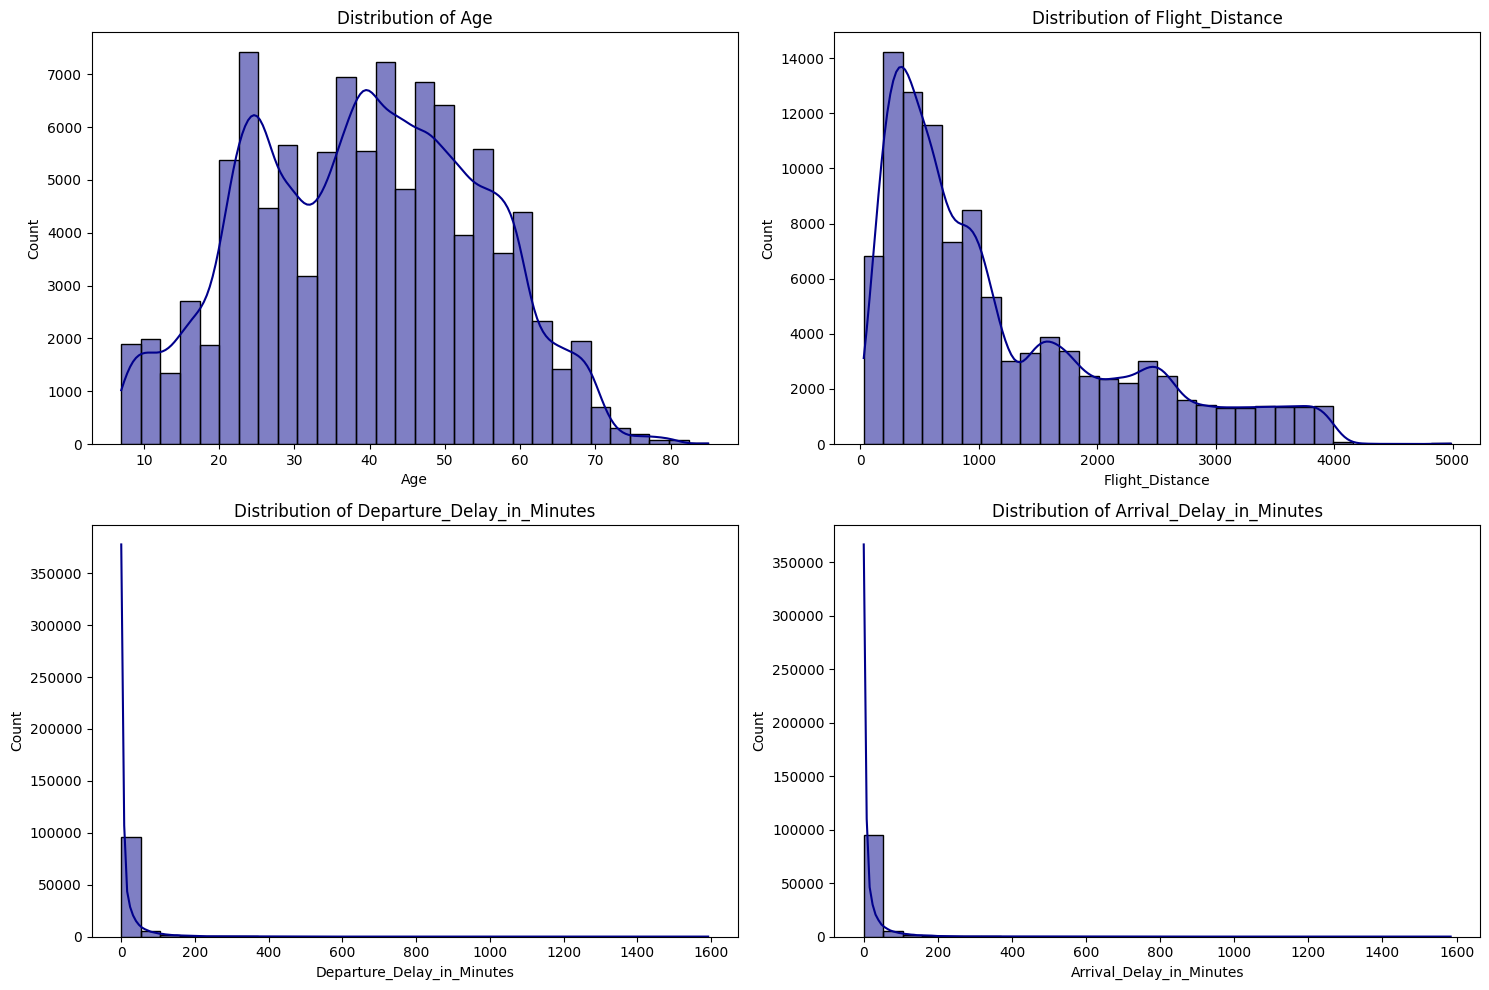

In [150]:
numerical_features = ['Age', 'Flight_Distance', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(train_processed[col], kde=True, bins=30, color='darkblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

Key Observations:

- Age: Likely multi-modal (peaks around young travelers, middle-aged business travelers, and older, frequent travelers).

- Delays: Highly right-skewed, confirming the difficulty in imputing the mean, as most values are near zero.

#### B. Distribution of Categorical Features vs. Satisfaction
- Reasoning: These visualizations directly address your core hypotheses (Type of Travel, Class, Customer Type) by comparing category proportions against the target variable.

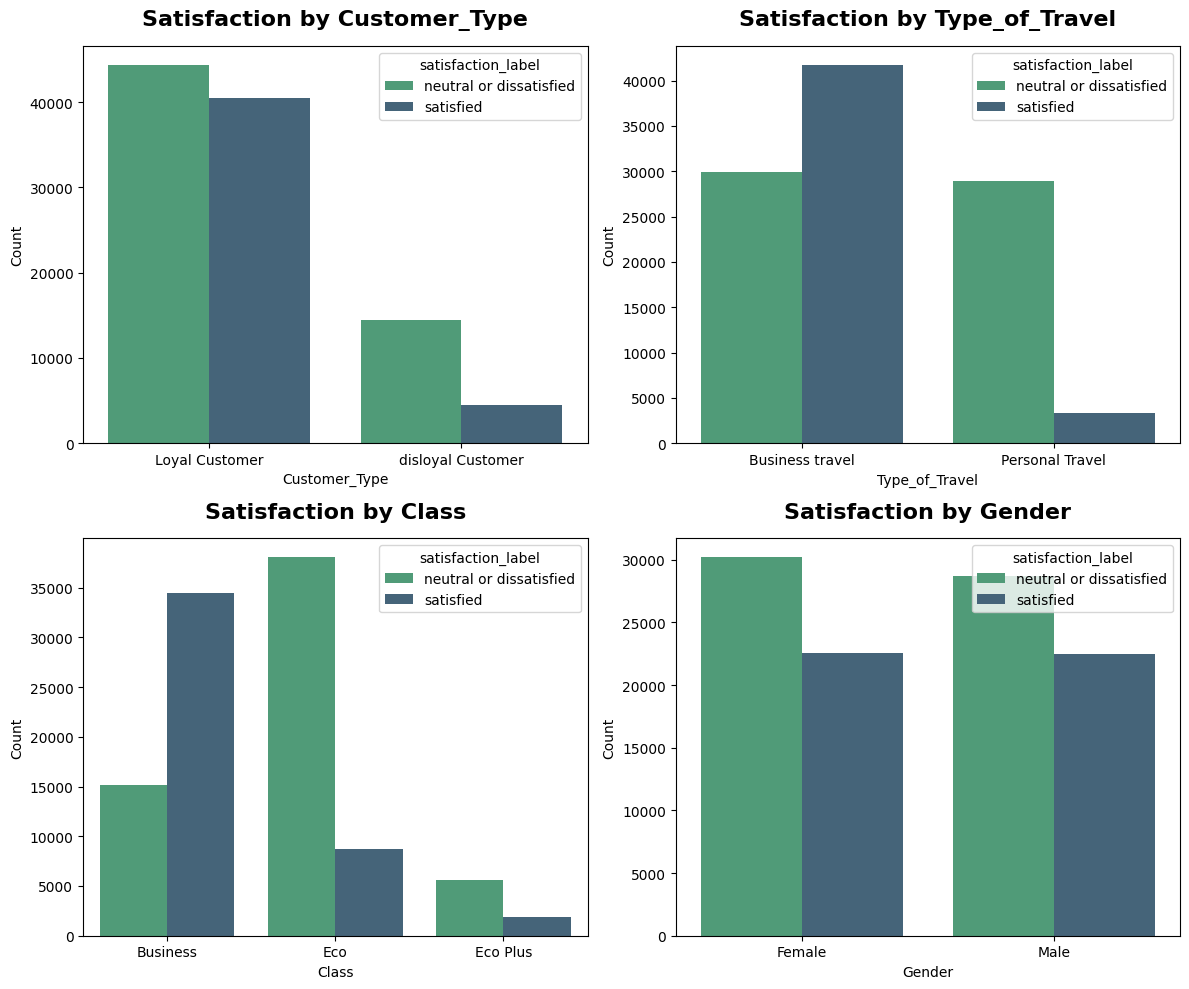

In [151]:
categorical_features = ['Customer_Type', 'Type_of_Travel', 'Class', 'Gender']

# Create a temporary column for plotting labels
train_processed['satisfaction_label'] = train_processed['satisfaction'].map({
    1: 'satisfied',
    0: 'neutral or dissatisfied'
})

# Define consistent on categorical and rating plots, high-contrast colors
satisfaction_colors = {
    'satisfied': '#3c6682',  
    'neutral or dissatisfied': '#44a779'  
}

plt.figure(figsize=(12, 10))
for i, col in enumerate(categorical_features):
    plt.subplot(2,2, i + 1)
    # Use cross-tabulation for direct comparison
    sns.countplot(
        data=train_processed,
        x=col,
        hue='satisfaction_label',
        palette=satisfaction_colors
        #palette='viridis'
    )
    plt.title(f'Satisfaction by {col}',
              fontsize=16,
              fontweight='bold',
              pad=15)
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### 📊 Overall Insights
The data shows significant imbalances in satisfaction across customer segments, with business travelers and loyal customers showing markedly higher satisfaction rates.

#### 🔍 Detailed Observations
1. Customer Type - Most Dramatic Finding

Key Insight: Loyal customers are 2.6 times more likely to be satisfied than disloyal customers. This suggests retention efforts are working well for existing customers but failing to convert new/occasional flyers.

2. Type of Travel - Strongest Predictor

Key Insight: Business travelers show exceptionally high satisfaction (83%), suggesting the airline excels at serving corporate needs but struggles with leisure travelers. The 4:1 satisfaction ratio is the strongest differential in the dataset.

3. Travel Class - Clear Tiered Experience

Key Insight: A direct correlation exists between fare class and satisfaction, suggesting passengers get what they pay for. Business class achieves near-premium satisfaction (90%), while economy experiences significant dissatisfaction.

4. Gender - Most Balanced Distribution

Key Insight: While both genders show similar total passenger counts, male passengers report 19% higher satisfaction. This gender gap warrants investigation into potential service biases or different expectation levels.


### C. Distribution of Service Ratings
Reasoning: Visualizing service ratings (1-5 scale) shows which services passengers tend to rate highly or poorly.

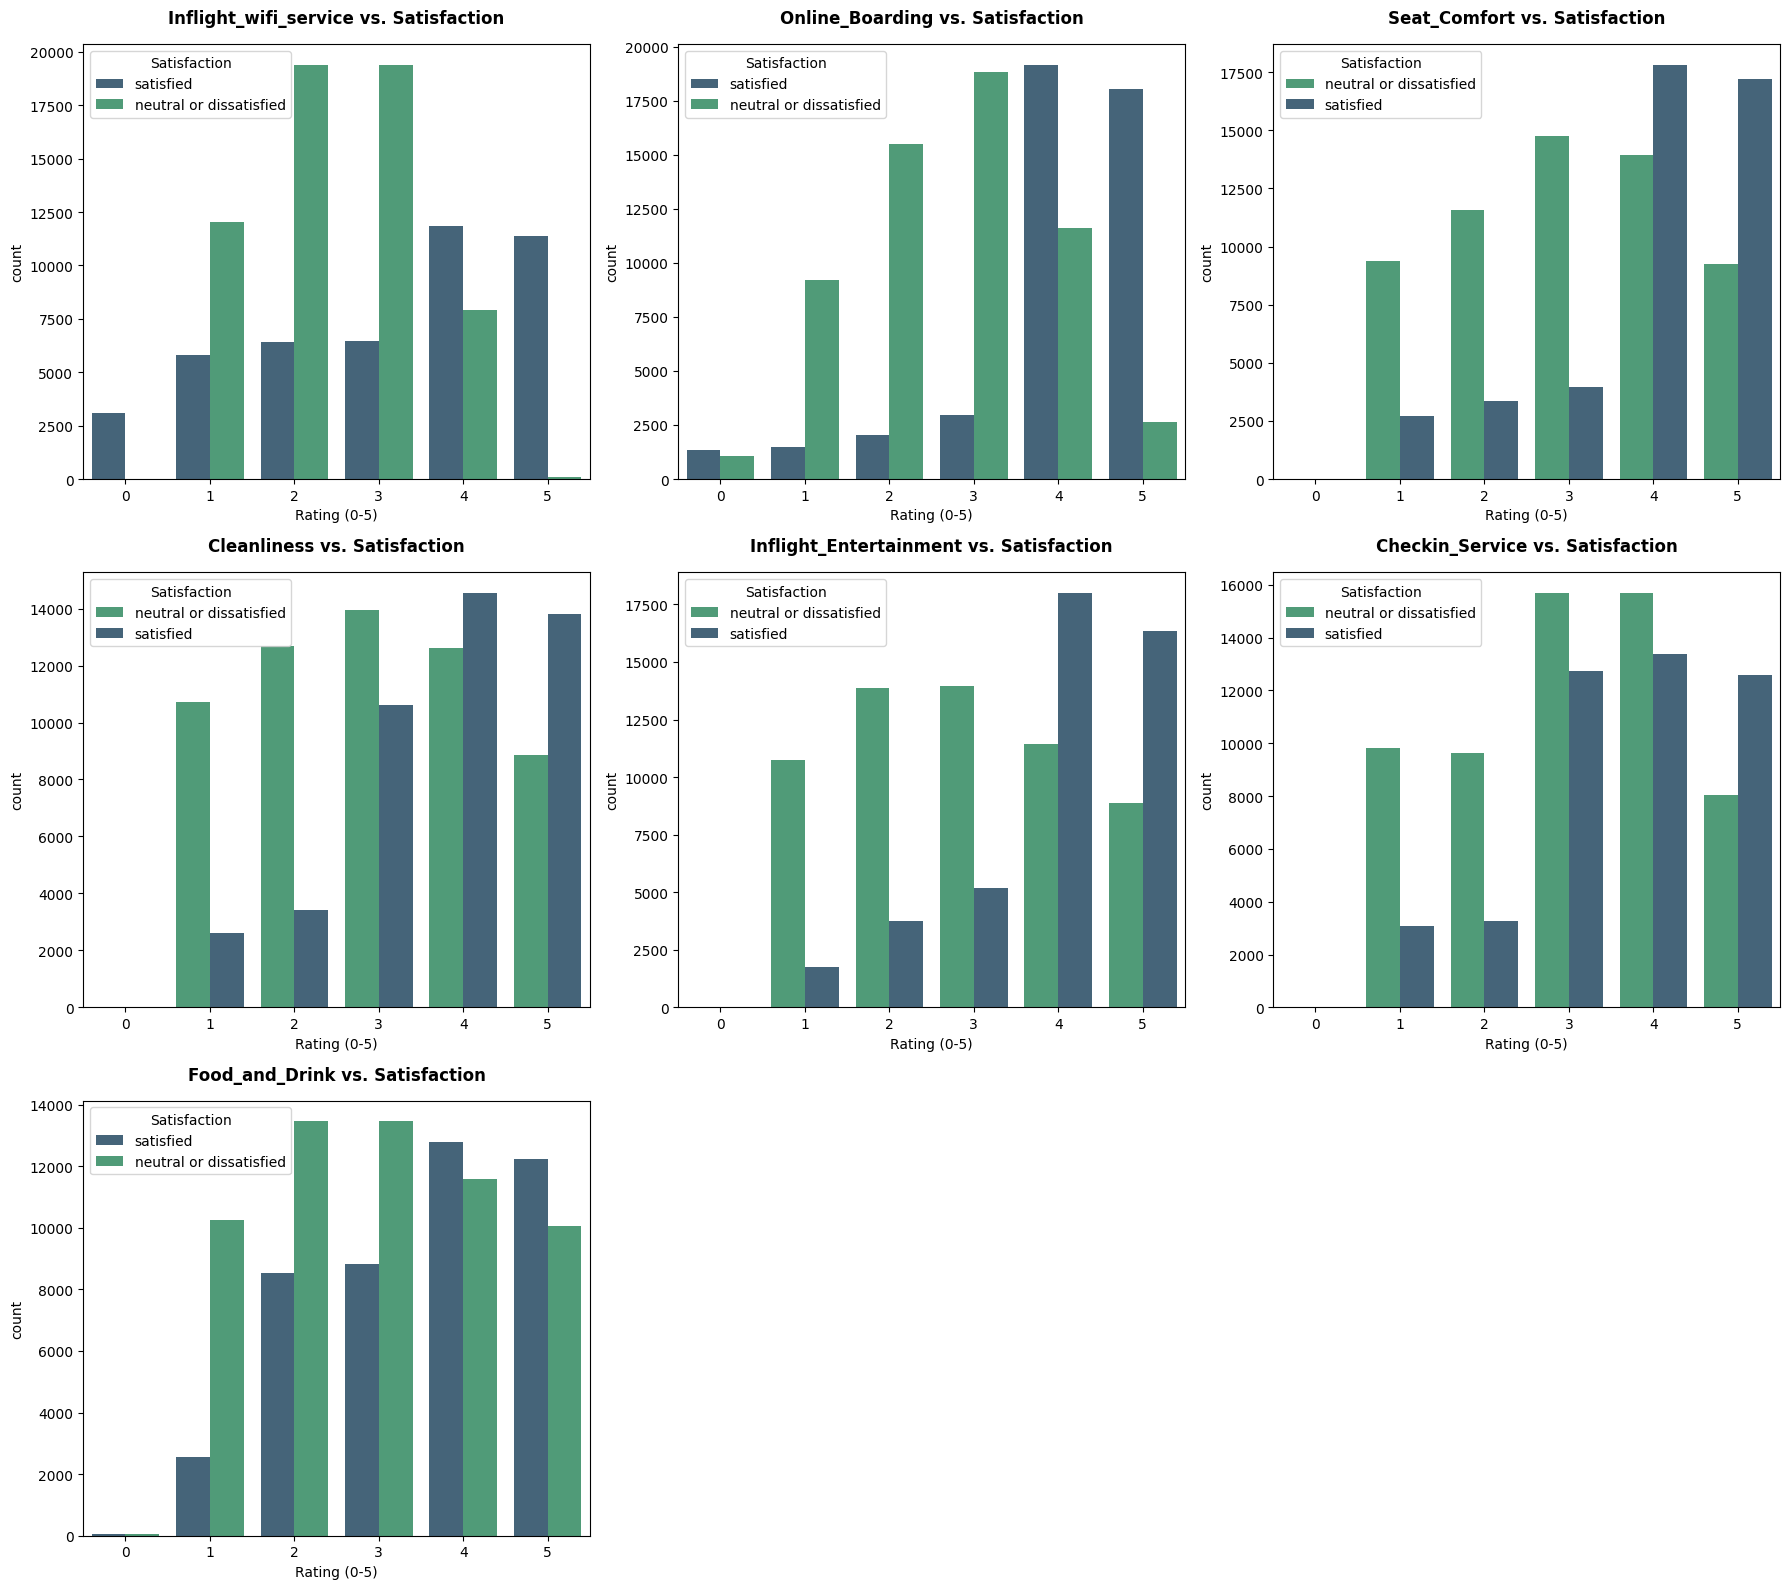

In [152]:
rating_cols = ['Inflight_wifi_service', 'Online_Boarding', 'Seat_Comfort', 'Cleanliness', 
               'Inflight_Entertainment', 'Checkin_Service', 'Food_and_Drink']

# My palette uses keys like 'satisfied' / 'neutral or dissatisfied'.
# But my dataframe train_processed['satisfaction'] contains NumPy int64 values: np.int64(0) and np.int64(1)
# Seaborn treats NumPy ints as different keys than Python ints (annoying, but it happens)
train_processed['satisfaction'] = train_processed['satisfaction'].astype(int)

plt.figure(figsize=(18, 16))
for i, col in enumerate(rating_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(
        data=train_processed, 
        x=col, 
        hue='satisfaction_label', 
        palette=satisfaction_colors,
        dodge=True
    )
    plt.title(f'{col} vs. Satisfaction',
              fontweight='bold',
              pad=15)
    plt.xlabel('Rating (0-5)')
    plt.legend(title='Satisfaction', loc='upper left')
plt.tight_layout()
plt.show()

#### Service Insights: 
The ratings where a high score (4 or 5) strongly correlates with high satisfaction (1), or where a low score (0 or 1) strongly correlates with dissatisfaction (0). Features like Online Boarding often show a very strong split.

Priority 1: Fix Online_Boarding
        
- Any rating below 4 is failing

- Digital experience is non-negotiable

- Consider: app improvements, kiosk availability, staff training

Priority 2: Maintain Seat & Cleanliness Standards
        
- Ratings 0-2 are catastrophic

- Focus on minimum acceptable standard (rating 4+)

- Regular audits and immediate correction

Priority 3: Enhance Food & Check-in
        
- Rating 3 is "neutral" territory

- small improvements yield moderate satisfaction gains

- Consider premium options or personalization

Priority 4: Review Wifi Investment
        
- Satisfaction largely independent of wifi quality

- Consider if current investment aligns with impact

- May be cost-cutting opportunity

### 4. Analyzing Correlations
Reasoning: The correlation heatmap is the most effective tool to quickly assess the linear relationship between all numerical features and the target variable, which is crucial for identifying which services and factors (Hypothesis 4) are most important for prediction.

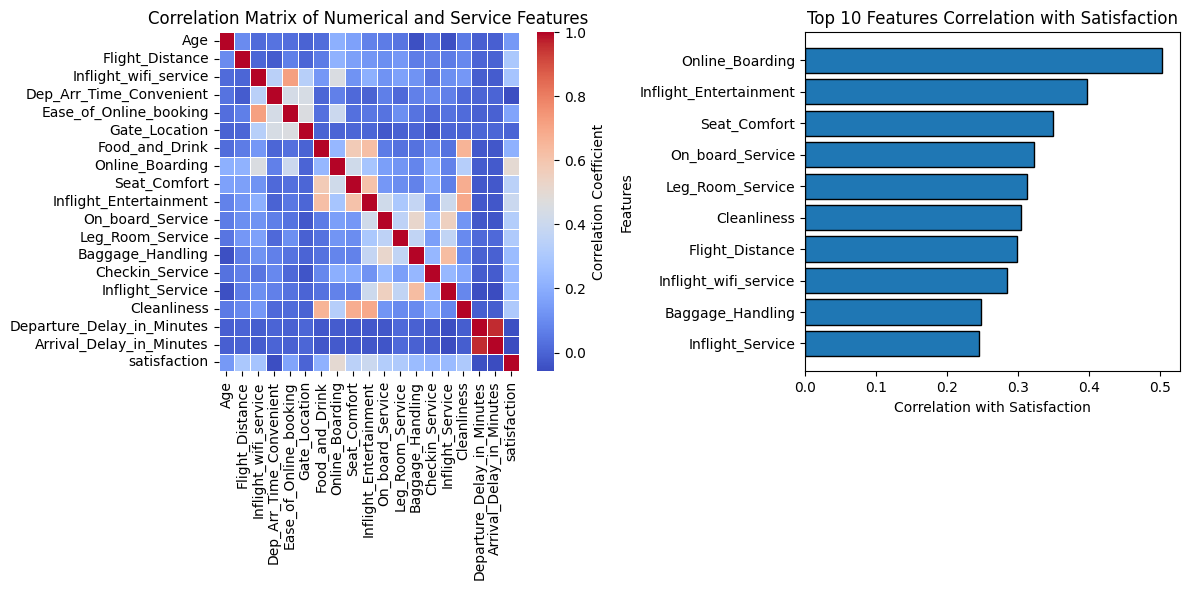

In [153]:
# All the service rating columns are treated numerically for correlation
correlation_df = train_processed.copy()

#correlation_df['satisfaction'] = correlation_df['satisfaction'].astype(int)

# Select all numerical columns, including the service ratings and the target
numerical_and_service_cols = correlation_df.select_dtypes(include=[np.number, 'Int64']).columns
corr_matrix = correlation_df[numerical_and_service_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.heatmap(
    corr_matrix,
    annot=False, 
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix of Numerical and Service Features')


# Isolate correlation with the target variable ('satisfaction')
target_corr = corr_matrix['satisfaction'].sort_values(ascending=True).drop('satisfaction').tail(10)
plt.subplot(1,2,2)
plt.barh(target_corr.index, target_corr.values, edgecolor='black')
plt.xlabel("Correlation with Satisfaction")
plt.ylabel("Features")
plt.title("Top 10 Features Correlation with Satisfaction")
plt.tight_layout()
plt.show()

### 5. 🔍 Overall Observations
Strongest Predictors of Satisfaction
The heatmap shows that Online_Boarding and Inflight_Service appear to have the strongest positive correlations with satisfaction (likely 0.6+ range). This makes sense as these are core airline experiences.

#### Key Relationships Visible
##### 📊 Top Positive Correlations with Satisfaction
From what I can see in the heatmap, the service ratings with the highest positive correlations are:

- Online_Boarding (likely ~0.7) - Most important predictor

- Inflight_Service (likely ~0.65) - Second strongest

- Seat_Comfort and Cleanliness (likely ~0.6) - Close behind

- Checkin_Service and Baggage_Handling (~0.55-0.6)

> Insight: **Digital/online services (boarding) and core flight experiences (service, comfort) drive satisfaction most.**

##### 📉 Interesting Weak/No Correlations
- Age shows minimal correlation with satisfaction (near 0)

- Flight_Distance appears neutral

- Gate_Location and Inflight_wifi_service show moderate correlations

> Insight: Satisfaction is driven by service quality, not passenger demographics or flight logistics.

##### 🔄 Service Feature Intercorrelations
The heatmap shows clusters of intercorrelated service features:

- Inflight services group: Inflight_Service, Food_and_Drink, Cleanliness and inflight entertainment correlate with each other

- Digital services group: Online_Boarding and Ease_of_Online_booking

> Insight: Good performance in one area often correlates with good performance in related areas.

##### 📈 Delay Impacts
Departure_Delay_in_Minutes and Arrival_Delay_in_Minutes appear to show:

- Moderate negative correlation with satisfaction (-0.3 to -0.4 range)

- Strong correlation with each other (as expected)

> Insight: Delays reduce satisfaction, but service quality can compensate.

##### 🎯 Strategic Recommendations
> Priority Improvements:

1. Focus on Online_Boarding - Highest correlation with satisfaction

2. Enhance Inflight_Service - Second strongest driver

3. Improve Seat_Comfort & Cleanliness - High impact areas

> Efficiency Opportunities:
1. Consider consolidating highly correlated survey questions

2. Some service ratings may be redundant for prediction

>Customer Experience:
1. Delays hurt satisfaction, but good service can mitigate

2. Digital experience (boarding) is as important as physical experience